In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from osgeo import ogr, gdal
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from tensorflow.keras.layers import Input, Activation, Dense, Conv2D, MaxPool2D, Dropout, concatenate, UpSampling2D, Flatten
from tensorflow.keras.models import Model, load_model, Sequential
import tensorflow.keras.backend as K
#from keras.layers.merge import concatenate, add

import os
from skimage.util.shape import view_as_windows
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [6]:
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [7]:
def load_tiff_image(image):
    print (image)
    gdal_header = gdal.Open(image)
    img = gdal_header.ReadAsArray()
    return img

def normalization(image):
    return np.array(image)/127.5 - 1.

def extract_patches(image, reference, patch_size, stride):
    patches_out = []
    label_out = []
    window_shape = patch_size
    window_shape_array = (window_shape, window_shape, image.shape[2])
    window_shape_ref = (window_shape, window_shape)
    patches_array = np.array(view_as_windows(image, window_shape_array, step = stride))
    
    patches_ref = np.array(view_as_windows(reference, window_shape_ref, step = stride))
    
    print(patches_array.shape)
    num_row,num_col,p,row,col,depth = patches_array.shape
    
    patches_array = patches_array.reshape(num_row*num_col,row,col,depth)
    print(patches_array.shape)
    patches_ref = patches_ref.reshape(num_row*num_col,row,col)
    print(patches_ref.shape)
    
    return patches_array, patches_ref

In [8]:
root_path = './dataset'
# Load images
img_train_path = 'clipped_raster_004_66_2018.tif'
img_train = load_tiff_image(os.path.join(root_path, img_train_path)).astype(np.float32)
img_train = img_train.transpose((1,2,0))
# Normalizes the image
#img_train_normalized = normalization(img_train)
# Transform the image into W x H x C shape
#img_train_normalized = img_train_normalized.transpose((1,2,0))
print(img_train.shape)

# Load reference
img_train_ref_path = 'labels/binary_clipped_2013_2018.tif'
img_train_ref = load_tiff_image(os.path.join(root_path, img_train_ref_path))
print(img_train_ref.shape)
# img_train_ref = img_train_ref.transpose((1,2,0))
# print(img_train_ref.shape)

# Load Mask area
img_mask_ref_path = 'mask_ref.tif'
img_mask_ref = load_tiff_image(os.path.join(root_path, img_mask_ref_path))
img_mask_ref = np.copy(img_mask_ref[:6102, :6613])
print(img_mask_ref.shape)

./dataset/clipped_raster_004_66_2018.tif


AttributeError: 'NoneType' object has no attribute 'ReadAsArray'

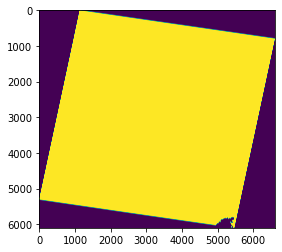

In [5]:
plt.imshow(img_mask_ref)

In [6]:
# Area preta
print(img_mask_ref[0, 0])
# Area amarela
print(img_mask_ref[3000, 4000])

-99.0
-1.0


In [12]:
# Area preta
print(img_train_ref[0, 0])
# Area amarela
print(img_train_ref[3000, 4000])
h,w = img_train_ref.shape
unique, counts = np.unique(img_train_ref, return_counts=True)
counts_dict = dict(zip(unique, counts))
print(counts_dict)

0.0
0.0
{0.0: 40287112, 1.0: 65414}


In [25]:
# Area preta
print(img_train[0, 0, :])
# Area amarela
print(img_train[3000, 4000, :])

[0. 0. 0. 0. 0. 0. 0.]
[ 9178.  8222.  7599.  6705. 16499. 10355.  7058.]


In [20]:
shape = img_mask_ref.shape
patches_train = []
patches_train_ref = []
new_img = np.array(())
patch_size = 128
stride = patch_size // 1
#stride = 1
num_patches_h = shape[0] // stride
num_patches_w = shape[1] // stride
print(f'Patche: {patch_size}')
print(f'Stride: {stride}')
print(f'Num patches h: {num_patches_h}')
print(f'Num patches w: {num_patches_w}')
for i in range(num_patches_h):
    for j in range(num_patches_w):
        #print(j*patch_size)
        patch = np.copy(img_mask_ref[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size])
        patch_train_ref = img_train_ref[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
        patch_train = img_train[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
        unique, counts = np.unique(patch_train_ref, return_counts=True)
        counts_dict = dict(zip(unique, counts))
        if 1 in counts_dict.keys():
            total_pixels = counts_dict[0] + counts_dict[1]
            if np.all(patch == -1) == True and counts_dict[1]/total_pixels >= 0.2:
                #print(counts_dict[1]/total_pixels)
                patches_train.append(patch_train)
                patches_train_ref.append(patch_train_ref)
            else:
                pass
print(len(patches_train))
print(len(patches_train_ref))
#patches=np.asarray(patches)

Patche: 128
Stride: 128
Num patches h: 47
Num patches w: 51
0
0


In [25]:
# Load reference
img_train_ref_path = '/media/thimabru/ssd/Deep_Learning_aula/Homework3_ELE2765/Reference_Train.tif'
img_train_ref = load_tiff_image(os.path.join(root_path, img_train_ref_path))
img_train_ref = img_train_ref.transpose((1,2,0))
print(img_train_ref.shape)
w = img_train_ref.shape[0]
h = img_train_ref.shape[1]
c = img_train_ref.shape[2]
#binary_img_train_ref = np.zeros((1,w,h))
binary_img_train_ref = np.full((w,h), -1)
label_dict = {'(255, 255, 255)': 0, '(0, 255, 0)': 1, '(0, 255, 255)': 2, '(0, 0, 255)': 3, '(255, 255, 0)': 4}
for i in range(w):
    for j in range(h):
        r = img_train_ref[i][j][0]
        g = img_train_ref[i][j][1]
        b = img_train_ref[i][j][2]
        rgb = (r,g,b)
        rgb_key = str(rgb)
        binary_img_train_ref[i][j] = label_dict[rgb_key]

/media/thimabru/ssd/Deep_Learning_aula/Homework3_ELE2765/Reference_Train.tif
(2565, 1919, 3)


In [32]:
shape = img_mask_ref.shape
patches = []
new_img = np.array(())
patch_size = 128
stride = patch_size // 4
#stride = 1
num_patches_h = shape[0] // stride
num_patches_w = shape[1] // stride
print(f'Patche: {patch_size}')
print(f'Stride: {stride}')
print(f'Num patches h: {num_patches_h}')
print(f'Num patches w: {num_patches_w}')
for i in range(num_patches_h):
    for j in range(num_patches_w):
        #print(j*patch_size)
        patch = np.copy(img_mask_ref[i*stride:(i+1)*stride, j*stride:(j+1)*stride])
        if np.all(patch == -1) == True:
#             #print(i,j)
#             print(len(patch.tolist()))
#             print(patch.shape)
            patches.append(patch)
        else:
            pass
print(len(patches))
#patches=np.asarray(patches)

Patche: 128
Stride: 32
Num patches h: 190
Num patches w: 206
28794


In [33]:
print(patches[0].shape)

(32, 32)


In [35]:
print(patches)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [34]:
shape = img_train_ref.shape
print(shape)

(2565, 1919, 3)


In [42]:
label_dict = {}
for i in range(shape[0]):
    for j in range(shape[1]):
        pixel = img_train_ref[i, j]
        pixel_key = str(pixel)
        if pixel_key not in label_dict.keys():
            label_dict[pixel_key] = 0
        else:
            label_dict[pixel_key] += 1
        #print(img_train_ref[i, j])
        #print(len(img_train[i, j]))

In [43]:
print(label_dict)

{'0.0': 38932622, '1.0': 1419902}


In [10]:
shape = img_train_normalized.shape
print(shape)
label_dict = {}
l = []
for i in tqdm(range(shape[0])):
    for j in range(shape[1]):
        pixels = img_train_normalized[i, j, :].tolist()
        if pixels not in l:
            print(pixels)
            l.append(pixels)
        
        #print(type(pixels))
#         if pixels.any() not in l:
#             l.append(pixels)
#             print(pixels)
#         if None in pixel:
#             print(pixel)
        #print(img_train_ref[i, j])
        #print(len(img_train[i, j]))



  0%|          | 0/6102 [00:00<?, ?it/s]

  0%|          | 12/6102 [00:00<00:51, 117.61it/s]

(6102, 6613, 7)
[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
[75.23529052734375, 67.45490264892578, 61.0313720703125, 53.0, 126.57646942138672, 74.3490219116211, 52.2156867980957]
[75.02352905273438, 67.22744750976562, 60.427452087402344, 52.60784149169922, 128.2392120361328, 73.26667022705078, 50.81960678100586]
[75.05490112304688, 67.5568618774414, 60.66274642944336, 53.13333511352539, 121.43921661376953, 71.93333435058594, 51.525489807128906]
[75.44705963134766, 67.78431701660156, 61.45490264892578, 53.69804000854492, 126.65489959716797, 75.0313720703125, 52.16862869262695]
[74.92156982421875, 67.26667022705078, 61.070587158203125, 52.3725471496582, 126.45882415771484, 74.86666870117188, 51.603919982910156]
[74.77255249023438, 66.86666870117188, 60.05882263183594, 51.80784225463867, 119.32941436767578, 73.66666412353516, 51.01568603515625]
[74.67842864990234, 67.0, 60.51372528076172, 52.02745056152344, 126.92941284179688, 74.52156829833984, 51.25882339477539]
[74.65489959716797, 66.82



  0%|          | 19/6102 [00:00<01:03, 96.47it/s] 

  0%|          | 24/6102 [00:00<01:26, 70.13it/s]


[74.41960906982422, 66.70195770263672, 59.79215621948242, 51.73725509643555, 121.65882110595703, 75.07058715820312, 51.8156852722168]
[74.09803771972656, 66.40392303466797, 59.35293960571289, 51.27450942993164, 118.17646789550781, 73.01568603515625, 50.85097885131836]
[74.14509582519531, 66.33333587646484, 60.04313659667969, 51.67451095581055, 139.062744140625, 73.80000305175781, 50.64706039428711]
[74.12940979003906, 66.51372528076172, 59.80784225463867, 52.23921585083008, 129.7372589111328, 73.80784606933594, 51.509803771972656]
[74.57646942138672, 67.13333129882812, 60.51372528076172, 52.98431396484375, 121.96470642089844, 75.2196044921875, 53.298038482666016]
[75.75294494628906, 68.51372528076172, 61.7529411315918, 54.52941131591797, 118.95294189453125, 80.4117660522461, 56.9058837890625]
[74.58431243896484, 67.08627319335938, 60.32548904418945, 52.521568298339844, 110.48235321044922, 72.64705657958984, 51.8156852722168]
[74.21568298339844, 66.57646942138672, 59.37647247314453, 51



  0%|          | 29/6102 [00:00<01:55, 52.50it/s]

[75.5254898071289, 67.64313507080078, 61.39215850830078, 53.39215850830078, 121.5882339477539, 76.30196380615234, 53.062744140625]
[75.0941162109375, 67.4313735961914, 61.039215087890625, 52.474510192871094, 123.28235626220703, 73.26667022705078, 51.235294342041016]
[74.92156982421875, 67.3372573852539, 61.141178131103516, 52.63137435913086, 132.1686248779297, 74.39608001708984, 51.30588150024414]
[75.07058715820312, 67.47843170166016, 61.494117736816406, 53.070587158203125, 139.9803924560547, 76.17646789550781, 52.03529357910156]
[75.24313354492188, 67.50196075439453, 61.25882339477539, 53.086273193359375, 141.10195922851562, 76.33333587646484, 52.09803771972656]
[75.47058868408203, 67.57254791259766, 60.976470947265625, 53.156864166259766, 131.8549041748047, 77.42353057861328, 53.0941162109375]
[75.24313354492188, 67.53333282470703, 61.43921661376953, 53.172550201416016, 134.81961059570312, 78.67058563232422, 53.282352447509766]
[75.16470336914062, 67.31372833251953, 61.0, 52.6235275



  1%|          | 34/6102 [00:00<02:33, 39.63it/s]


[74.62352752685547, 66.85098266601562, 60.13725662231445, 51.69804000854492, 133.90196228027344, 74.55294036865234, 51.01568603515625]
[74.36470794677734, 66.6941146850586, 59.572547912597656, 51.22745132446289, 121.56470489501953, 69.5882339477539, 49.415687561035156]
[74.5058822631836, 66.99215698242188, 59.97254943847656, 51.72941207885742, 118.73332977294922, 69.25098419189453, 49.8470573425293]
[74.71764373779297, 67.23529052734375, 61.32156753540039, 52.764705657958984, 137.8313751220703, 72.92156982421875, 50.898040771484375]
[74.82745361328125, 67.19607543945312, 61.68235397338867, 53.125492095947266, 140.34901428222656, 77.12548828125, 52.2470588684082]
[75.03921508789062, 67.3686294555664, 60.898040771484375, 53.21176528930664, 126.23136901855469, 77.44705963134766, 53.29019546508789]
[74.8431396484375, 67.188232421875, 61.141178131103516, 53.07843017578125, 132.31764221191406, 76.16078186035156, 52.639217376708984]
[75.00784301757812, 67.23529052734375, 61.32156753540039, 5



  1%|          | 38/6102 [00:00<03:19, 30.45it/s]


[75.01568603515625, 67.14117431640625, 60.08235168457031, 52.19215774536133, 122.92156982421875, 73.94902038574219, 51.56470489501953]
[75.29804229736328, 67.36078643798828, 60.568626403808594, 52.599998474121094, 129.6039276123047, 74.94509887695312, 51.6588249206543]
[75.32157135009766, 67.36078643798828, 60.686275482177734, 52.686275482177734, 128.63922119140625, 75.4313735961914, 51.7215690612793]
[74.95294189453125, 67.0941162109375, 60.23137283325195, 52.46666717529297, 121.50196075439453, 74.2549057006836, 51.431373596191406]
[75.14117431640625, 67.13333129882812, 59.94902038574219, 52.19215774536133, 117.6823501586914, 73.07058715820312, 51.101959228515625]
[75.50196075439453, 67.50196075439453, 60.552940368652344, 52.35686111450195, 132.05882263183594, 73.57254791259766, 51.40784454345703]
[75.38431549072266, 67.44705963134766, 60.505882263183594, 52.427452087402344, 129.42352294921875, 78.02745056152344, 52.85097885131836]
[75.21176147460938, 66.9686279296875, 59.43137359619



  1%|          | 42/6102 [00:01<04:11, 24.07it/s]

[75.38431549072266, 67.66666412353516, 59.94902038574219, 52.843135833740234, 106.42745208740234, 68.45098114013672, 50.56078338623047]
[75.05490112304688, 67.32157135009766, 59.6588249206543, 52.23921585083008, 109.10195922851562, 66.77255249023438, 49.29019546508789]
[75.19607543945312, 67.35294342041016, 61.070587158203125, 53.45490264892578, 118.14509582519531, 72.79608154296875, 51.50196075439453]
[75.04705810546875, 66.96078491210938, 59.282352447509766, 51.76862716674805, 114.08235168457031, 65.90196228027344, 48.458824157714844]
[75.24313354492188, 67.35294342041016, 60.23921585083008, 52.874507904052734, 116.05882263183594, 70.76470947265625, 50.780391693115234]
[75.76863098144531, 68.01960754394531, 61.619606018066406, 53.83137130737305, 133.29803466796875, 77.04705810546875, 52.92156982421875]
[75.3372573852539, 67.67450714111328, 61.69804000854492, 53.36862564086914, 141.02352905273438, 79.83921813964844, 53.266666412353516]
[75.188232421875, 67.32941436767578, 60.584312438



  1%|          | 45/6102 [00:01<05:20, 18.87it/s]


[74.57646942138672, 66.82745361328125, 59.64313888549805, 51.83137130737305, 119.50980377197266, 71.54117584228516, 50.40392303466797]
[74.88235473632812, 67.26667022705078, 59.64313888549805, 52.34901809692383, 113.11764526367188, 68.9686279296875, 50.05097961425781]
[74.45882415771484, 66.52941131591797, 58.86666488647461, 51.203922271728516, 116.98431396484375, 67.76078796386719, 49.266666412353516]
[74.48235321044922, 67.00784301757812, 60.2470588684082, 52.27058792114258, 121.34510040283203, 72.63921356201172, 50.9058837890625]
[75.29019927978516, 67.69019317626953, 61.25882339477539, 53.525489807128906, 131.19607543945312, 78.12156677246094, 53.90980529785156]
[75.83137512207031, 68.23136901855469, 61.572547912597656, 54.717647552490234, 127.87059020996094, 79.98039245605469, 55.61176300048828]
[75.42353057861328, 67.78431701660156, 61.43921661376953, 53.51764678955078, 134.18431091308594, 78.23921203613281, 53.494117736816406]
[75.1568603515625, 67.56470489501953, 61.2352943420



  1%|          | 48/6102 [00:01<06:35, 15.29it/s]


[75.25882720947266, 67.47058868408203, 60.75686264038086, 52.411766052246094, 133.5490264892578, 74.71764373779297, 51.69804000854492]
[75.45490264892578, 67.5568618774414, 60.85097885131836, 52.552940368652344, 124.19215393066406, 74.7254867553711, 51.47058868408203]
[75.84706115722656, 68.05097961425781, 60.52941131591797, 53.141178131103516, 111.82353210449219, 71.32157135009766, 51.086273193359375]
[75.95686340332031, 68.03529357910156, 60.764705657958984, 53.48627471923828, 117.062744140625, 73.0, 52.05097961425781]
[75.0941162109375, 67.36078643798828, 60.14509963989258, 52.11372375488281, 122.34117889404297, 72.12156677246094, 50.54509735107422]
[75.29804229736328, 67.35294342041016, 60.427452087402344, 52.26274490356445, 127.188232421875, 72.67058563232422, 50.81960678100586]
[75.57254791259766, 67.44705963134766, 60.70980453491211, 52.380393981933594, 128.49803161621094, 74.67842864990234, 51.086273193359375]
[75.70587921142578, 67.64313507080078, 60.49803924560547, 52.529411

[74.88235473632812, 67.10980224609375, 60.11372375488281, 52.29411697387695, 119.87843322753906, 70.26274871826172, 50.46666717529297]
[74.87451171875, 66.99215698242188, 60.599998474121094, 52.599998474121094, 130.0431365966797, 76.46666717529297, 52.796077728271484]
[74.87451171875, 67.16470336914062, 60.458824157714844, 52.552940368652344, 131.9254913330078, 73.63529205322266, 51.188236236572266]
[74.79608154296875, 66.9686279296875, 60.3725471496582, 52.27058792114258, 128.72549438476562, 72.37255096435547, 50.537254333496094]
[74.6313705444336, 66.91372680664062, 60.54509735107422, 52.16078567504883, 132.2705841064453, 74.91372680664062, 51.509803771972656]
[74.82745361328125, 66.77255249023438, 59.33725357055664, 51.58039093017578, 120.2862777709961, 71.65882110595703, 50.521568298339844]
[75.00784301757812, 67.42353057861328, 60.843135833740234, 52.654903411865234, 123.34510040283203, 71.03921508789062, 50.66274642944336]
[75.32157135009766, 67.39215850830078, 61.27450942993164,



  1%|          | 50/6102 [00:01<09:38, 10.46it/s]

[73.97254943847656, 66.09019470214844, 59.250980377197266, 51.19607925415039, 123.3686294555664, 71.54117584228516, 49.7843132019043]
[73.87843322753906, 66.06666564941406, 58.827449798583984, 50.86666488647461, 126.52156829833984, 71.80784606933594, 50.17647171020508]
[74.2862777709961, 66.41960906982422, 60.26274490356445, 52.05097961425781, 130.9058837890625, 74.09019470214844, 51.086273193359375]
[73.44705963134766, 65.92549133300781, 59.509803771972656, 51.188236236572266, 130.57647705078125, 71.062744140625, 50.01960754394531]
[73.76863098144531, 65.90196228027344, 59.062744140625, 51.125492095947266, 119.83137512207031, 69.83137512207031, 49.8470573425293]
[73.70587921142578, 65.97254943847656, 58.537254333496094, 51.16470718383789, 113.0313720703125, 67.07058715820312, 49.619606018066406]
[73.69803619384766, 66.06666564941406, 59.525489807128906, 51.572547912597656, 115.3372573852539, 66.68627166748047, 48.443138122558594]
[74.09803771972656, 66.42745208740234, 61.1647071838378



  1%|          | 52/6102 [00:02<10:17,  9.80it/s]


[75.54117584228516, 67.50980377197266, 60.33333206176758, 52.17647171020508, 122.86666870117188, 72.85098266601562, 51.007843017578125]
[75.60391998291016, 67.57254791259766, 60.19215774536133, 52.31764602661133, 125.36078643798828, 74.71764373779297, 51.37647247314453]
[75.6509780883789, 67.6509780883789, 60.22352981567383, 52.3725471496582, 129.18038940429688, 76.04313659667969, 51.7843132019043]
[75.44705963134766, 67.41568756103516, 59.79215621948242, 52.13725662231445, 125.12548828125, 72.48235321044922, 50.62352752685547]
[75.39215850830078, 67.3372573852539, 59.82352828979492, 52.16862869262695, 122.08235168457031, 69.76078796386719, 49.7529411315918]
[75.26667022705078, 67.23529052734375, 60.20784378051758, 52.04313659667969, 125.98039245605469, 71.22744750976562, 50.20784378051758]
[75.188232421875, 67.35294342041016, 60.599998474121094, 52.1843147277832, 135.38430786132812, 75.36078643798828, 51.313724517822266]
[75.39215850830078, 67.41568756103516, 60.86666488647461, 52.49



  1%|          | 54/6102 [00:02<11:09,  9.04it/s]


[75.29019927978516, 67.25098419189453, 60.34901809692383, 52.780391693115234, 123.14901733398438, 71.2196044921875, 50.568626403808594]
[74.99215698242188, 67.32941436767578, 61.360782623291016, 53.172550201416016, 135.36862182617188, 76.19215393066406, 52.427452087402344]
[74.92941284179688, 67.19607543945312, 61.77647018432617, 52.490196228027344, 149.68235778808594, 77.87059020996094, 52.521568298339844]
[75.12548828125, 67.1568603515625, 61.086273193359375, 52.49803924560547, 135.50196838378906, 77.00784301757812, 52.33333206176758]
[75.20391845703125, 67.32157135009766, 60.74117660522461, 52.72549057006836, 135.0, 77.07843017578125, 52.59215545654297]
[75.03921508789062, 67.00784301757812, 59.64313888549805, 51.87843322753906, 120.70195770263672, 71.62744903564453, 50.23137283325195]
[74.96078491210938, 66.92941284179688, 59.494117736816406, 51.87843322753906, 107.73725128173828, 66.3176498413086, 48.843135833740234]
[75.18038940429688, 67.43921661376953, 61.125492095947266, 52.7

[73.78431701660156, 66.33333587646484, 60.2156867980957, 51.8470573425293, 128.16078186035156, 76.4117660522461, 52.77254867553711]
[74.15293884277344, 66.30196380615234, 59.97254943847656, 52.13725662231445, 135.78431701660156, 76.55294036865234, 52.443138122558594]
[73.82353210449219, 66.07450866699219, 59.250980377197266, 51.91764831542969, 124.40392303466797, 73.4000015258789, 51.8470573425293]
[74.13725280761719, 66.2862777709961, 59.88627624511719, 52.11372375488281, 125.77647399902344, 76.4431381225586, 53.235294342041016]
[73.87843322753906, 66.23921203613281, 59.203922271728516, 51.7215690612793, 119.61176300048828, 74.49019622802734, 52.01960754394531]
[73.59607696533203, 66.12940979003906, 59.400001525878906, 51.478431701660156, 120.08235168457031, 73.0941162109375, 51.313724517822266]
[73.86274719238281, 66.26274871826172, 59.85490036010742, 51.7529411315918, 127.22744750976562, 74.85882568359375, 51.91764831542969]
[74.21568298339844, 66.43529510498047, 60.34901809692383, 



  1%|          | 56/6102 [00:02<12:15,  8.22it/s]

[75.2745132446289, 67.41568756103516, 60.75686264038086, 52.654903411865234, 131.90980529785156, 74.46666717529297, 51.556861877441406]
[75.0313720703125, 67.3372573852539, 60.81960678100586, 52.717647552490234, 134.0431365966797, 76.70195770263672, 52.16078567504883]
[75.0, 66.91372680664062, 59.98039245605469, 51.99607849121094, 122.75686645507812, 69.83137512207031, 49.89411926269531]
[75.04705810546875, 67.12548828125, 59.313724517822266, 51.97254943847656, 115.3686294555664, 67.90980529785156, 49.125492095947266]
[75.45490264892578, 67.5882339477539, 61.400001525878906, 53.54901885986328, 129.61961364746094, 79.59607696533203, 53.94902038574219]
[75.4000015258789, 67.41568756103516, 61.070587158203125, 52.86666488647461, 130.9686279296875, 74.2549057006836, 51.619606018066406]
[75.80000305175781, 67.99607849121094, 61.6588249206543, 53.69804000854492, 135.8000030517578, 77.25882720947266, 53.054901123046875]
[75.47843170166016, 67.65882110595703, 61.27450942993164, 53.470588684082



  1%|          | 58/6102 [00:03<13:33,  7.43it/s]


[74.85098266601562, 66.95294189453125, 59.01568603515625, 51.48627471923828, 109.83137512207031, 69.00784301757812, 49.32156753540039]
[74.49019622802734, 66.58431243896484, 58.49803924560547, 51.117645263671875, 103.87059020996094, 63.98039245605469, 47.478431701660156]
[74.85882568359375, 66.74901580810547, 59.35293960571289, 51.619606018066406, 115.54901885986328, 66.9058837890625, 48.59215545654297]
[74.5058822631836, 66.42745208740234, 59.29019546508789, 51.33725357055664, 113.98039245605469, 66.98431396484375, 48.26274490356445]
[75.14901733398438, 66.95294189453125, 59.97254943847656, 51.89411926269531, 128.54510498046875, 74.22352600097656, 51.086273193359375]
[74.58431243896484, 66.75686645507812, 59.0313720703125, 51.43921661376953, 110.21568298339844, 67.3372573852539, 49.039215087890625]
[75.05490112304688, 67.00784301757812, 59.72941207885742, 51.80784225463867, 120.46666717529297, 71.0313720703125, 49.99607849121094]
[75.13333129882812, 67.19607543945312, 61.258823394775



  1%|          | 59/6102 [00:03<14:25,  6.98it/s]


[73.95686340332031, 66.16862487792969, 59.282352447509766, 51.10980224609375, 123.94117736816406, 73.36078643798828, 50.654903411865234]
[74.05882263183594, 66.45882415771484, 59.39215850830078, 51.7843132019043, 113.77647399902344, 72.89804077148438, 51.33725357055664]
[73.79216003417969, 66.08235168457031, 58.615684509277344, 51.18039321899414, 113.90980529785156, 67.85490417480469, 49.30588150024414]
[74.11372375488281, 66.3490219116211, 59.619606018066406, 51.72941207885742, 122.03529357910156, 71.81568908691406, 50.701961517333984]
[74.5999984741211, 66.8431396484375, 60.858821868896484, 52.584312438964844, 130.63922119140625, 75.45490264892578, 51.77647018432617]
[74.60784149169922, 66.91372680664062, 60.46666717529297, 52.59215545654297, 129.10195922851562, 79.59607696533203, 53.54901885986328]
[74.3803939819336, 66.52941131591797, 60.01176452636719, 51.79215621948242, 127.20391845703125, 77.02352905273438, 52.46666717529297]
[74.48235321044922, 66.91372680664062, 59.7372550964



  1%|          | 60/6102 [00:03<14:38,  6.88it/s]

  1%|          | 61/6102 [00:03<15:57,  6.31it/s]


[75.41568756103516, 67.24313354492188, 59.87843322753906, 51.91764831542969, 127.56471252441406, 76.45882415771484, 52.1529426574707]
[75.26667022705078, 67.10195922851562, 59.400001525878906, 51.79999923706055, 118.02745056152344, 69.08627319335938, 49.556861877441406]
[75.39215850830078, 67.3058853149414, 59.88627624511719, 52.26274490356445, 124.74901580810547, 73.25098419189453, 50.95294189453125]
[75.3686294555664, 67.38431549072266, 60.3411750793457, 52.34901809692383, 127.47842407226562, 72.811767578125, 51.039215087890625]
[75.6823501586914, 67.87059020996094, 61.43921661376953, 53.42353057861328, 139.8549041748047, 79.02352905273438, 53.415687561035156]
[75.79216003417969, 67.99607849121094, 61.541175842285156, 53.7529411315918, 143.5098114013672, 85.14117431640625, 55.79215621948242]
[75.99607849121094, 67.91764831542969, 60.98431396484375, 53.345096588134766, 134.09803771972656, 82.07450866699219, 54.796077728271484]
[75.87059020996094, 67.80784606933594, 60.20784378051758,


[74.4117660522461, 66.61568450927734, 60.02745056152344, 52.16862869262695, 124.52941131591797, 76.92156982421875, 52.733333587646484]
[74.58431243896484, 67.14901733398438, 60.9058837890625, 53.36862564086914, 128.0431365966797, 77.96470642089844, 54.380393981933594]
[74.48235321044922, 66.92156982421875, 61.101959228515625, 52.945098876953125, 134.4196014404297, 80.23136901855469, 54.796077728271484]
[74.39608001708984, 66.76470947265625, 60.16078567504883, 52.54509735107422, 127.63529968261719, 76.43529510498047, 52.584312438964844]
[74.42745208740234, 66.811767578125, 59.619606018066406, 52.48235321044922, 119.6509780883789, 73.0941162109375, 51.8156852722168]
[74.23921203613281, 66.39608001708984, 58.443138122558594, 52.01176452636719, 107.66666412353516, 65.95686340332031, 48.505882263183594]
[74.14509582519531, 66.45098114013672, 59.070587158203125, 51.8156852722168, 116.27059173583984, 70.07450866699219, 50.427452087402344]
[74.55294036865234, 67.02352905273438, 60.26274490356

  1%|          | 62/6102 [00:03<18:07,  5.56it/s]

  1%|          | 63/6102 [00:04<19:16,  5.22it/s]

[73.72940826416016, 65.94117736816406, 59.13333511352539, 51.384315490722656, 123.92549133300781, 75.99607849121094, 51.56470489501953]
[73.61176300048828, 66.03529357910156, 59.250980377197266, 51.086273193359375, 124.83529663085938, 73.53333282470703, 50.60784149169922]
[73.79216003417969, 66.04313659667969, 58.929412841796875, 51.125492095947266, 116.79608154296875, 74.86666870117188, 50.929412841796875]
[73.99607849121094, 66.10588073730469, 59.619606018066406, 51.33725357055664, 120.22352600097656, 72.20783996582031, 50.427452087402344]
[73.95686340332031, 66.19215393066406, 59.462745666503906, 51.8156852722168, 118.83529663085938, 71.7137222290039, 51.062744140625]
[73.91764831542969, 66.23136901855469, 60.08235168457031, 51.88627624511719, 134.38038635253906, 72.88235473632812, 51.400001525878906]
[73.87843322753906, 66.3490219116211, 60.521568298339844, 52.04313659667969, 137.6666717529297, 77.01568603515625, 52.38823699951172]
[73.62744903564453, 65.72156524658203, 59.22745132



  1%|          | 64/6102 [00:04<20:27,  4.92it/s]

[73.82353210449219, 66.00392150878906, 59.32156753540039, 51.64313888549805, 125.58039093017578, 74.5372543334961, 51.329410552978516]
[73.6196060180664, 66.03529357910156, 59.29019546508789, 51.431373596191406, 123.5254898071289, 72.56078338623047, 51.141178131103516]
[73.66666412353516, 66.20783996582031, 59.59607696533203, 51.93333435058594, 122.21568298339844, 72.58431243896484, 51.541175842285156]
[73.91764831542969, 66.03529357910156, 59.89411926269531, 51.51764678955078, 131.0313720703125, 75.4627456665039, 51.65098190307617]
[73.77647399902344, 66.17646789550781, 59.7529411315918, 51.494117736816406, 122.64705657958984, 72.91372680664062, 50.717647552490234]
[73.87843322753906, 65.99607849121094, 59.007843017578125, 51.360782623291016, 124.91372680664062, 72.01176452636719, 50.2470588684082]
[73.69019317626953, 65.83137512207031, 59.40784454345703, 51.062744140625, 136.811767578125, 74.5999984741211, 51.10980224609375]
[73.53333282470703, 65.72940826416016, 59.203922271728516, 

[73.90980529785156, 66.19999694824219, 59.8156852722168, 51.69804000854492, 126.46666717529297, 76.12156677246094, 52.3098030090332]
[74.01176452636719, 66.19215393066406, 59.0, 51.6588249206543, 115.47843170166016, 71.3372573852539, 50.898040771484375]
[74.00392150878906, 66.17646789550781, 58.60784149169922, 51.37647247314453, 116.14509582519531, 69.65882110595703, 50.3725471496582]
[74.12940979003906, 66.51372528076172, 59.97254943847656, 51.97254943847656, 134.41175842285156, 76.3490219116211, 52.12941360473633]
[74.37255096435547, 66.76470947265625, 59.72941207885742, 52.1529426574707, 121.10980224609375, 74.96078491210938, 52.30195999145508]
[74.45882415771484, 66.82745361328125, 60.11372375488281, 52.35686111450195, 118.92941284179688, 74.41960906982422, 52.19215774536133]
[74.4745101928711, 66.89019775390625, 60.07450866699219, 52.25490188598633, 119.77647399902344, 73.3058853149414, 51.48627471923828]
[73.95686340332031, 66.36470794677734, 59.266666412353516, 51.68235397338867



  1%|          | 65/6102 [00:04<21:55,  4.59it/s]

[76.64705657958984, 68.73332977294922, 61.22745132446289, 53.086273193359375, 131.48626708984375, 75.062744140625, 51.47058868408203]
[76.89804077148438, 68.91372680664062, 61.235294342041016, 53.235294342041016, 133.5725555419922, 77.13333129882812, 52.19215774536133]
[77.11764526367188, 69.13333129882812, 61.64313888549805, 53.525489807128906, 136.2392120361328, 79.40784454345703, 53.070587158203125]
[77.25882720947266, 69.24313354492188, 62.03529357910156, 53.73725509643555, 136.60784912109375, 78.12940979003906, 52.41960906982422]
[77.25882720947266, 69.08627319335938, 61.266666412353516, 53.21176528930664, 124.16862487792969, 72.4745101928711, 50.396080017089844]
[77.22744750976562, 69.14901733398438, 60.992156982421875, 53.22745132446289, 113.23529052734375, 69.94902038574219, 49.88627624511719]
[77.29804229736328, 69.28235626220703, 61.43921661376953, 53.59607696533203, 117.96470642089844, 71.01568603515625, 50.670589447021484]
[77.0, 69.07843017578125, 61.67451095581055, 53.470



  1%|          | 66/6102 [00:04<22:39,  4.44it/s]


[77.11764526367188, 68.94509887695312, 61.91764831542969, 53.54901885986328, 134.99215698242188, 78.96078491210938, 53.125492095947266]
[77.25098419189453, 69.3058853149414, 61.79999923706055, 53.76078414916992, 133.83921813964844, 77.92549133300781, 52.945098876953125]
[77.20391845703125, 69.22744750976562, 61.64313888549805, 53.68235397338867, 127.68235778808594, 76.54509735107422, 52.20784378051758]
[77.45490264892578, 69.58039093017578, 62.717647552490234, 54.490196228027344, 144.38038635253906, 80.46666717529297, 53.525489807128906]
[77.14117431640625, 69.2196044921875, 62.05882263183594, 53.89411926269531, 132.66275024414062, 78.73332977294922, 52.66274642944336]
[76.94509887695312, 69.03921508789062, 61.0313720703125, 53.156864166259766, 119.89411926269531, 72.89804077148438, 50.85097885131836]
[77.14117431640625, 69.062744140625, 61.203922271728516, 53.50196075439453, 118.97647094726562, 72.39608001708984, 51.21176528930664]
[77.2196044921875, 69.23529052734375, 61.52548980712



  1%|          | 67/6102 [00:05<24:09,  4.16it/s]

[75.4313735961914, 67.41568756103516, 60.639217376708984, 52.537254333496094, 133.7058868408203, 77.86274719238281, 52.2470588684082]
[75.78431701660156, 67.87843322753906, 60.960784912109375, 53.494117736816406, 129.41567993164062, 81.56470489501953, 54.9058837890625]
[75.35294342041016, 67.50980377197266, 61.172550201416016, 52.81960678100586, 139.72157287597656, 81.69019317626953, 54.32548904418945]
[74.96078491210938, 66.99215698242188, 59.0313720703125, 51.35293960571289, 117.77647399902344, 68.17646789550781, 49.10980224609375]
[75.25882720947266, 67.20391845703125, 59.69804000854492, 52.12156677246094, 121.73725128173828, 72.05882263183594, 50.505882263183594]
[75.85490417480469, 67.83921813964844, 61.14902114868164, 53.32156753540039, 132.00392150878906, 78.12156677246094, 53.101959228515625]
[75.4941177368164, 67.63529205322266, 61.156864166259766, 52.86666488647461, 138.98431396484375, 78.91372680664062, 52.568626403808594]
[75.2745132446289, 67.3686294555664, 60.882354736328



  1%|          | 68/6102 [00:05<24:31,  4.10it/s]


[74.99215698242188, 67.16470336914062, 60.427452087402344, 52.12941360473633, 123.29019927978516, 70.60784149169922, 49.94902038574219]
[75.36078643798828, 67.34510040283203, 61.282352447509766, 52.60784149169922, 132.91372680664062, 74.96078491210938, 51.141178131103516]
[75.26667022705078, 67.43921661376953, 61.282352447509766, 52.505882263183594, 140.02745056152344, 77.2745132446289, 51.64313888549805]
[75.11764526367188, 67.2745132446289, 60.3411750793457, 52.05882263183594, 126.49803924560547, 73.4313735961914, 50.639217376708984]
[74.95294189453125, 66.99215698242188, 59.73725509643555, 51.74509811401367, 116.45098114013672, 69.20391845703125, 49.45490264892578]
[74.96078491210938, 67.07058715820312, 60.30195999145508, 51.98823547363281, 127.69020080566406, 73.3372573852539, 50.490196228027344]
[75.11764526367188, 67.35294342041016, 60.858821868896484, 52.36470413208008, 135.1568603515625, 76.91372680664062, 51.91764831542969]
[75.188232421875, 67.3686294555664, 61.1490211486816



  1%|          | 69/6102 [00:05<25:51,  3.89it/s]


[75.23529052734375, 66.89804077148438, 59.32156753540039, 51.76078414916992, 117.32941436767578, 70.16862487792969, 49.86274337768555]
[75.26667022705078, 67.28235626220703, 59.603919982910156, 52.01176452636719, 117.62744903564453, 71.39215850830078, 50.749019622802734]
[75.25882720947266, 67.4313735961914, 59.99607849121094, 52.22352981567383, 124.73332977294922, 73.5568618774414, 51.22745132446289]
[75.5254898071289, 67.6823501586914, 60.505882263183594, 52.49803924560547, 127.83921813964844, 73.81568908691406, 51.71372604370117]
[75.79216003417969, 67.72156524658203, 60.913726806640625, 52.937255859375, 126.62352752685547, 74.71764373779297, 52.764705657958984]
[75.4627456665039, 67.4627456665039, 60.07450866699219, 52.45098114013672, 123.4313735961914, 73.35294342041016, 51.556861877441406]
[75.25882720947266, 67.29804229736328, 59.72941207885742, 52.28627395629883, 116.57646942138672, 69.90196228027344, 50.33333206176758]
[75.3686294555664, 67.42353057861328, 60.48235321044922, 



  1%|          | 70/6102 [00:05<26:00,  3.86it/s]


[73.77647399902344, 66.11372375488281, 59.7215690612793, 51.70588302612305, 127.76863098144531, 75.95686340332031, 51.8156852722168]
[73.70587921142578, 66.04313659667969, 59.235294342041016, 51.47058868408203, 122.70195770263672, 75.2196044921875, 51.98823547363281]
[73.82353210449219, 66.05097961425781, 59.37647247314453, 51.51764678955078, 126.08235168457031, 74.59215545654297, 51.85490036010742]
[73.80000305175781, 66.01176452636719, 59.054901123046875, 51.0313720703125, 116.78823852539062, 74.45098114013672, 51.13333511352539]
[73.6823501586914, 66.00392150878906, 58.552940368652344, 50.86666488647461, 113.2196044921875, 71.07058715820312, 50.43529510498047]
[74.19999694824219, 66.3176498413086, 59.29019546508789, 51.619606018066406, 122.85098266601562, 72.08235168457031, 50.83529281616211]
[74.03529357910156, 66.23136901855469, 59.266666412353516, 51.77647018432617, 117.90196228027344, 67.54117584228516, 49.56470489501953]
[74.6313705444336, 66.94509887695312, 60.19215774536133,

[74.19999694824219, 66.42745208740234, 59.360782623291016, 51.61176300048828, 120.24705505371094, 72.87451171875, 51.203922271728516]
[74.24705505371094, 66.3803939819336, 59.64313888549805, 51.88627624511719, 122.27843475341797, 74.88235473632812, 51.89411926269531]
[74.20783996582031, 66.4431381225586, 59.98823547363281, 52.16078567504883, 117.45490264892578, 73.188232421875, 51.67451095581055]
[74.40392303466797, 66.70195770263672, 60.584312438964844, 53.007843017578125, 124.10588073730469, 74.65489959716797, 52.521568298339844]
[74.49803924560547, 66.94509887695312, 60.937255859375, 53.415687561035156, 125.39215850830078, 76.23921203613281, 53.18039321899414]
[74.79608154296875, 67.4313735961914, 61.51764678955078, 54.749019622802734, 124.06666564941406, 76.27843475341797, 53.92549133300781]
[74.70980072021484, 66.80392456054688, 60.874507904052734, 53.32156753540039, 122.89019775390625, 74.16078186035156, 51.87058639526367]
[74.07450866699219, 66.23921203613281, 59.76862716674805,



  1%|          | 71/6102 [00:06<30:17,  3.32it/s]

[74.62352752685547, 66.5686264038086, 59.56470489501953, 51.588233947753906, 125.90196228027344, 72.78823852539062, 50.898040771484375]
[74.5372543334961, 66.45882415771484, 58.83529281616211, 51.24313735961914, 112.64705657958984, 68.00392150878906, 49.24313735961914]
[74.4431381225586, 66.56078338623047, 59.101959228515625, 51.61176300048828, 112.20783996582031, 67.17254638671875, 49.19607925415039]
[74.74117279052734, 66.8431396484375, 59.71372604370117, 51.83921432495117, 123.72940826416016, 71.48627471923828, 50.07450866699219]
[74.95294189453125, 67.03921508789062, 60.13725662231445, 52.08235168457031, 130.03529357910156, 74.51372528076172, 51.062744140625]
[75.11764526367188, 67.31372833251953, 60.701961517333984, 52.796077728271484, 134.60000610351562, 78.43529510498047, 53.313724517822266]
[75.34510040283203, 67.53333282470703, 61.19607925415039, 53.47058868408203, 138.50588989257812, 80.92156982421875, 54.63137435913086]
[75.21176147460938, 67.32157135009766, 60.5999984741210

[75.02352905273438, 67.78431701660156, 61.062744140625, 54.25490188598633, 113.4627456665039, 75.69803619384766, 54.23921585083008]
[74.67842864990234, 66.89019775390625, 60.16078567504883, 52.69411849975586, 115.97254943847656, 74.16862487792969, 52.06666564941406]
[74.29412078857422, 66.49803924560547, 59.63529586791992, 51.494117736816406, 111.54117584228516, 71.45490264892578, 50.38823699951172]
[74.5999984741211, 66.79608154296875, 60.639217376708984, 52.41960906982422, 126.33333587646484, 72.38823699951172, 51.07843017578125]
[74.37255096435547, 66.58431243896484, 60.07450866699219, 52.3725471496582, 122.2862777709961, 73.07058715820312, 51.36862564086914]
[74.37255096435547, 66.37255096435547, 59.39215850830078, 51.79215621948242, 121.3372573852539, 71.18038940429688, 50.20000076293945]
[74.27059173583984, 66.32549285888672, 59.266666412353516, 50.929412841796875, 118.67842864990234, 66.37255096435547, 48.30195999145508]
[74.36470794677734, 66.58431243896484, 60.05882263183594, 



  1%|          | 72/6102 [00:06<31:09,  3.23it/s]


[75.53333282470703, 67.4941177368164, 60.701961517333984, 52.86666488647461, 125.72156524658203, 77.04705810546875, 52.77254867553711]
[75.42353057861328, 67.36078643798828, 60.929412841796875, 52.69411849975586, 133.313720703125, 78.01960754394531, 52.827449798583984]
[75.34510040283203, 67.32941436767578, 61.0313720703125, 52.780391693115234, 134.89019775390625, 78.52941131591797, 53.30588150024414]
[75.1568603515625, 67.13333129882812, 60.26274490356445, 52.46666717529297, 124.71764373779297, 74.16862487792969, 51.77647018432617]
[74.7803955078125, 66.76470947265625, 59.48627471923828, 51.80784225463867, 120.14509582519531, 70.65489959716797, 50.380393981933594]
[74.58431243896484, 66.71764373779297, 59.478431701660156, 51.94902038574219, 118.16078186035156, 71.4941177368164, 50.874507904052734]
[74.7254867553711, 66.83529663085938, 59.58039093017578, 52.23921585083008, 116.30980682373047, 72.30196380615234, 51.59607696533203]
[75.32941436767578, 67.44705963134766, 60.4509811401367



  1%|          | 73/6102 [00:06<31:05,  3.23it/s]

[75.2196044921875, 67.29019927978516, 59.96470642089844, 52.1843147277832, 117.25098419189453, 71.79216003417969, 50.584312438964844]
[75.23529052734375, 67.3372573852539, 60.411766052246094, 52.40392303466797, 125.44705963134766, 73.92549133300781, 51.0941162109375]
[75.0941162109375, 67.188232421875, 60.36470413208008, 52.19215774536133, 122.38823699951172, 73.32157135009766, 50.72549057006836]
[75.12548828125, 67.13333129882812, 60.27058792114258, 52.02745056152344, 128.72549438476562, 73.78431701660156, 50.95294189453125]
[75.14901733398438, 67.25882720947266, 60.74117660522461, 52.2470588684082, 133.02352905273438, 76.83529663085938, 51.97254943847656]
[75.23529052734375, 67.26667022705078, 60.976470947265625, 52.40392303466797, 135.52549743652344, 76.17646789550781, 51.82352828979492]
[75.12548828125, 67.14117431640625, 60.874507904052734, 52.36470413208008, 134.97647094726562, 76.9058837890625, 51.8156852722168]
[75.25882720947266, 67.2196044921875, 60.898040771484375, 52.372547

[74.67058563232422, 66.77255249023438, 59.603919982910156, 51.82352828979492, 116.19215393066406, 70.11372375488281, 49.88627624511719]
[74.68627166748047, 66.88235473632812, 59.87058639526367, 52.1843147277832, 123.18038940429688, 72.4431381225586, 50.56078338623047]
[74.49803924560547, 66.65489959716797, 59.7843132019043, 51.89411926269531, 128.67843627929688, 73.62744903564453, 51.039215087890625]
[74.40392303466797, 66.68627166748047, 60.16078567504883, 51.73725509643555, 127.94117736816406, 73.35294342041016, 50.95294189453125]
[74.3176498413086, 66.78823852539062, 61.63529586791992, 52.17647171020508, 132.24705505371094, 74.83529663085938, 51.086273193359375]
[74.11372375488281, 66.3490219116211, 59.141178131103516, 51.32156753540039, 117.58039093017578, 70.39608001708984, 49.87843322753906]
[74.12156677246094, 66.3176498413086, 59.32156753540039, 51.54901885986328, 113.2196044921875, 70.30196380615234, 50.41960906982422]
[74.07450866699219, 66.4117660522461, 59.400001525878906, 



  1%|          | 74/6102 [00:07<34:15,  2.93it/s]

[76.59215545654297, 68.43529510498047, 60.521568298339844, 52.67843246459961, 120.98431396484375, 71.60391998291016, 50.22352981567383]
[76.48235321044922, 68.58431243896484, 61.19607925415039, 52.929412841796875, 127.74510192871094, 75.188232421875, 51.18039321899414]
[76.6313705444336, 68.57646942138672, 61.509803771972656, 53.345096588134766, 131.75294494628906, 76.23921203613281, 51.98039245605469]
[76.87451171875, 68.85098266601562, 61.494117736816406, 53.51764678955078, 129.4078369140625, 77.6509780883789, 52.686275482177734]
[76.91372680664062, 68.76470947265625, 60.9686279296875, 53.172550201416016, 118.7254867553711, 72.74901580810547, 50.976470947265625]
[76.77255249023438, 68.6313705444336, 60.72549057006836, 52.827449798583984, 110.27843475341797, 67.4941177368164, 48.843135833740234]
[76.88235473632812, 68.77255249023438, 60.74117660522461, 53.141178131103516, 110.99215698242188, 67.77647399902344, 49.478431701660156]
[76.75686645507812, 68.79608154296875, 60.6941184997558



  1%|          | 75/6102 [00:07<34:10,  2.94it/s]


[74.85882568359375, 67.062744140625, 60.490196228027344, 52.57646942138672, 125.80000305175781, 77.5568618774414, 52.654903411865234]
[74.63921356201172, 66.8431396484375, 60.04313659667969, 52.05097961425781, 123.54901885986328, 72.94509887695312, 51.43921661376953]
[75.00784301757812, 66.94509887695312, 60.27058792114258, 52.443138122558594, 121.89411926269531, 75.50980377197266, 52.3411750793457]
[74.9686279296875, 66.9686279296875, 59.83137130737305, 52.23921585083008, 116.95294189453125, 75.1568603515625, 51.7215690612793]
[74.95294189453125, 67.05490112304688, 59.36862564086914, 51.88627624511719, 117.14117431640625, 70.80392456054688, 50.40392303466797]
[75.31372833251953, 67.29019927978516, 60.31764602661133, 52.686275482177734, 123.47843170166016, 75.37647247314453, 52.02745056152344]
[75.14117431640625, 67.08627319335938, 60.30195999145508, 52.584312438964844, 127.4705810546875, 73.62744903564453, 51.400001525878906]
[74.9686279296875, 67.03921508789062, 61.219608306884766, 

[74.21568298339844, 66.3490219116211, 59.33725357055664, 51.7843132019043, 112.85882568359375, 71.42353057861328, 50.937255859375]
[74.23136901855469, 66.46666717529297, 59.478431701660156, 51.94902038574219, 113.72940826416016, 71.94902038574219, 51.007843017578125]
[74.05097961425781, 66.48235321044922, 60.07450866699219, 51.76078414916992, 121.14901733398438, 73.69803619384766, 51.007843017578125]
[74.17646789550781, 66.45882415771484, 60.12941360473633, 51.67451095581055, 120.88235473632812, 73.4313735961914, 50.749019622802734]
[74.4745101928711, 66.70980072021484, 59.83137130737305, 52.00392150878906, 114.04313659667969, 72.85882568359375, 51.062744140625]
[74.70980072021484, 67.0313720703125, 60.380393981933594, 52.639217376708984, 120.5372543334961, 76.52941131591797, 52.960784912109375]
[74.70195770263672, 66.92941284179688, 60.3411750793457, 52.474510192871094, 118.79608154296875, 75.29804229736328, 52.09019470214844]
[74.6313705444336, 66.80392456054688, 60.654903411865234, 



  1%|          | 76/6102 [00:08<34:47,  2.89it/s]

[76.42745208740234, 68.74117279052734, 62.16862869262695, 53.76862716674805, 136.77255249023438, 78.01960754394531, 53.086273193359375]
[76.3490219116211, 68.45882415771484, 61.0, 53.27450942993164, 126.91372680664062, 74.2549057006836, 51.329410552978516]
[76.42745208740234, 68.21568298339844, 60.14509963989258, 52.38823699951172, 109.1568603515625, 64.76470947265625, 48.26274490356445]
[76.67842864990234, 68.74117279052734, 62.57646942138672, 53.8470573425293, 137.26666259765625, 74.5372543334961, 51.43921661376953]
[76.8431396484375, 69.08627319335938, 62.764705657958984, 54.45098114013672, 142.9686279296875, 78.48235321044922, 52.764705657958984]
[76.5686264038086, 68.67058563232422, 61.541175842285156, 53.50196075439453, 134.1137237548828, 74.04313659667969, 51.556861877441406]
[76.5999984741211, 68.81961059570312, 62.04313659667969, 53.71372604370117, 124.22352600097656, 70.86666870117188, 50.49803924560547]
[76.5372543334961, 68.87451171875, 61.7215690612793, 54.12941360473633, 



  1%|▏         | 77/6102 [00:08<35:31,  2.83it/s]

[75.20391845703125, 67.32941436767578, 60.796077728271484, 52.35686111450195, 140.1137237548828, 77.24313354492188, 52.00392150878906]
[75.39215850830078, 67.37647247314453, 60.16862869262695, 52.16862869262695, 126.24705505371094, 72.7803955078125, 50.764705657958984]
[75.37647247314453, 67.65882110595703, 60.717647552490234, 52.843135833740234, 125.3058853149414, 72.97647094726562, 51.0313720703125]
[75.6196060180664, 67.72156524658203, 61.51764678955078, 53.14902114868164, 142.5294189453125, 79.5568618774414, 53.16470718383789]
[75.5882339477539, 67.77647399902344, 61.39215850830078, 52.898040771484375, 141.75294494628906, 80.30196380615234, 53.37647247314453]
[76.12940979003906, 68.2549057006836, 61.51764678955078, 53.71372604370117, 133.65882873535156, 79.80784606933594, 53.94117736816406]
[76.43529510498047, 68.6627426147461, 61.91764831542969, 54.54509735107422, 131.93333435058594, 82.14509582519531, 55.56470489501953]
[76.20783996582031, 68.16078186035156, 61.29019546508789, 53

[74.70980072021484, 67.21176147460938, 60.882354736328125, 53.39215850830078, 125.6823501586914, 78.35686492919922, 54.35686111450195]
[74.82745361328125, 67.11764526367188, 60.57646942138672, 53.45490264892578, 123.25882720947266, 76.3176498413086, 52.945098876953125]
[75.03921508789062, 67.04705810546875, 59.87058639526367, 52.66274642944336, 120.5058822631836, 76.49803924560547, 52.654903411865234]
[74.43529510498047, 66.6627426147461, 59.36862564086914, 51.70588302612305, 115.97254943847656, 71.05490112304688, 50.458824157714844]
[74.54509735107422, 66.98431396484375, 60.57646942138672, 52.898040771484375, 121.41568756103516, 71.81568908691406, 51.282352447509766]
[74.33333587646484, 66.7803955078125, 60.63137435913086, 52.04313659667969, 126.62352752685547, 73.42353057861328, 51.266666412353516]
[74.64705657958984, 67.02352905273438, 60.05097961425781, 51.97254943847656, 119.4627456665039, 73.98039245605469, 51.188236236572266]
[74.52941131591797, 66.89019775390625, 59.70588302612



  1%|▏         | 78/6102 [00:08<39:27,  2.54it/s]


[74.76470947265625, 66.61568450927734, 59.22745132446289, 51.80784225463867, 113.6823501586914, 70.49019622802734, 50.1843147277832]
[75.0313720703125, 67.11764526367188, 60.11372375488281, 52.56078338623047, 117.19607543945312, 71.81568908691406, 51.35293960571289]
[74.92156982421875, 67.05490112304688, 60.1529426574707, 52.40392303466797, 121.10195922851562, 73.78431701660156, 51.77647018432617]
[74.89019775390625, 66.74901580810547, 59.6901969909668, 51.494117736816406, 119.10195922851562, 69.24313354492188, 49.431373596191406]
[74.82745361328125, 66.86666870117188, 60.43529510498047, 51.7215690612793, 136.60000610351562, 71.87059020996094, 50.36470413208008]
[75.0, 67.07843017578125, 60.30195999145508, 51.94117736816406, 124.19999694824219, 73.18038940429688, 50.717647552490234]
[74.88235473632812, 67.07058715820312, 59.82352828979492, 51.85490036010742, 119.80784606933594, 70.92156982421875, 50.25490188598633]
[75.17254638671875, 67.062744140625, 60.07450866699219, 52.12156677246

[74.35686492919922, 66.54509735107422, 59.8470573425293, 51.76862716674805, 121.72156524658203, 73.66666412353516, 51.572547912597656]
[74.15293884277344, 66.3803939819336, 60.3098030090332, 52.03529357910156, 129.42352294921875, 76.98431396484375, 52.615684509277344]
[74.3176498413086, 66.55294036865234, 59.313724517822266, 51.7529411315918, 117.03921508789062, 72.95294189453125, 51.117645263671875]
[74.29412078857422, 66.4117660522461, 59.235294342041016, 51.74509811401367, 117.80784606933594, 72.29412078857422, 50.976470947265625]
[74.43529510498047, 66.74901580810547, 60.02745056152344, 52.60784149169922, 121.40784454345703, 76.2862777709961, 53.24313735961914]
[74.45882415771484, 66.9686279296875, 60.74117660522461, 53.19607925415039, 134.811767578125, 81.24313354492188, 55.18039321899414]
[74.12156677246094, 66.49019622802734, 59.94902038574219, 52.36470413208008, 126.33333587646484, 76.3176498413086, 52.75686264038086]
[73.80000305175781, 66.04313659667969, 59.250980377197266, 5



  1%|▏         | 79/6102 [00:09<41:43,  2.41it/s]

[75.5882339477539, 67.50196075439453, 60.639217376708984, 52.552940368652344, 128.62353515625, 74.13725280761719, 51.235294342041016]
[75.41568756103516, 67.50196075439453, 60.30195999145508, 52.30195999145508, 128.15293884277344, 73.22744750976562, 50.717647552490234]
[75.43921661376953, 67.50980377197266, 60.02745056152344, 52.380393981933594, 126.13725280761719, 71.95686340332031, 50.3098030090332]
[75.50196075439453, 67.43921661376953, 59.93333435058594, 52.41960906982422, 121.47843170166016, 70.92941284179688, 50.03529357910156]
[75.53333282470703, 67.60391998291016, 60.2784309387207, 52.51372528076172, 121.5568618774414, 70.87451171875, 50.23137283325195]
[75.3372573852539, 67.35294342041016, 60.20784378051758, 52.14509963989258, 124.39608001708984, 72.17646789550781, 50.615684509277344]
[75.10195922851562, 67.21176147460938, 59.86274337768555, 51.93333435058594, 115.03921508789062, 71.0313720703125, 50.14509963989258]
[75.48627471923828, 67.70587921142578, 60.06666564941406, 52.

[74.2549057006836, 66.64705657958984, 60.3098030090332, 52.2784309387207, 124.79608154296875, 78.3803939819336, 53.19607925415039]
[74.37255096435547, 66.6313705444336, 60.31764602661133, 52.38823699951172, 124.937255859375, 78.51372528076172, 52.717647552490234]
[74.17646789550781, 66.42745208740234, 59.68235397338867, 51.86274337768555, 127.20391845703125, 77.20391845703125, 52.13725662231445]
[73.81568908691406, 66.27843475341797, 59.6901969909668, 51.77647018432617, 127.10195922851562, 75.07843017578125, 51.94117736816406]
[73.94902038574219, 66.39608001708984, 60.796077728271484, 52.16862869262695, 135.30587768554688, 76.78823852539062, 52.36470413208008]
[73.69803619384766, 66.16078186035156, 60.80392074584961, 52.00392150878906, 138.7803955078125, 75.43921661376953, 51.7843132019043]
[73.60391998291016, 65.98823547363281, 59.86274337768555, 51.92549133300781, 132.72549438476562, 74.23921203613281, 51.77647018432617]
[73.87059020996094, 66.05097961425781, 60.02745056152344, 52.09



  1%|▏         | 80/6102 [00:09<41:36,  2.41it/s]


[75.0, 67.03921508789062, 59.8470573425293, 51.77647018432617, 117.70587921142578, 69.23529052734375, 49.37647247314453]
[75.87059020996094, 68.16862487792969, 61.588233947753906, 53.47058868408203, 130.70196533203125, 75.92549133300781, 52.599998474121094]
[75.22744750976562, 67.0313720703125, 60.04313659667969, 51.7215690612793, 124.23921203613281, 72.15293884277344, 50.06666564941406]
[75.16470336914062, 67.07058715820312, 60.2156867980957, 51.95686340332031, 130.34901428222656, 75.07843017578125, 51.478431701660156]
[74.92941284179688, 67.08627319335938, 60.474510192871094, 52.04313659667969, 132.25489807128906, 74.9686279296875, 51.13333511352539]
[75.07058715820312, 67.19607543945312, 61.384315490722656, 52.78823471069336, 135.53334045410156, 76.11372375488281, 51.74509811401367]
[74.86666870117188, 67.08627319335938, 61.117645263671875, 52.615684509277344, 134.51373291015625, 76.46666717529297, 51.7843132019043]
[75.14901733398438, 67.37647247314453, 60.85097885131836, 52.47451



  1%|▏         | 81/6102 [00:10<41:15,  2.43it/s]

[73.65882110595703, 65.7137222290039, 58.23137283325195, 50.733333587646484, 108.14509582519531, 70.20783996582031, 49.478431701660156]
[73.90980529785156, 65.97254943847656, 58.9058837890625, 51.541175842285156, 112.5999984741211, 72.18431091308594, 50.615684509277344]
[74.09019470214844, 66.30196380615234, 59.65098190307617, 51.80784225463867, 119.4627456665039, 75.51764678955078, 52.03529357910156]
[73.95686340332031, 66.15293884277344, 58.77254867553711, 50.960784912109375, 108.26274871826172, 70.12940979003906, 49.73725509643555]
[74.30196380615234, 66.65489959716797, 59.8470573425293, 52.19215774536133, 116.64705657958984, 73.58039093017578, 51.40784454345703]
[74.16078186035156, 66.67058563232422, 60.443138122558594, 52.51372528076172, 122.86666870117188, 77.54901885986328, 53.37647247314453]
[74.37255096435547, 66.60784149169922, 59.48627471923828, 52.14509963989258, 118.27059173583984, 74.6941146850586, 51.7215690612793]
[74.37255096435547, 66.6313705444336, 59.478431701660156



  1%|▏         | 82/6102 [00:10<41:48,  2.40it/s]

[74.52156829833984, 66.74117279052734, 60.22352981567383, 51.96470642089844, 130.92941284179688, 78.39608001708984, 52.858821868896484]
[74.23136901855469, 66.5372543334961, 60.45098114013672, 51.98039245605469, 134.63922119140625, 77.2745132446289, 52.38823699951172]
[74.4431381225586, 66.75686645507812, 61.070587158203125, 52.505882263183594, 142.98431396484375, 80.16078186035156, 53.64313888549805]
[74.11372375488281, 66.58431243896484, 60.64706039428711, 52.31764602661133, 131.7686309814453, 75.76863098144531, 52.03529357910156]
[74.54509735107422, 66.68627166748047, 61.01568603515625, 52.26274490356445, 144.06666564941406, 78.68627166748047, 52.59215545654297]
[74.32549285888672, 66.7254867553711, 60.22352981567383, 52.1529426574707, 138.1764678955078, 78.10588073730469, 52.67843246459961]
[74.16862487792969, 66.34117889404297, 59.89411926269531, 52.04313659667969, 132.51373291015625, 76.7254867553711, 52.35686111450195]
[74.40392303466797, 66.85882568359375, 60.75686264038086, 52

[73.88627624511719, 66.01176452636719, 59.329410552978516, 51.400001525878906, 127.54902648925781, 70.61568450927734, 49.68235397338867]
[73.84706115722656, 66.04313659667969, 59.67451095581055, 51.266666412353516, 125.43921661376953, 69.14117431640625, 49.203922271728516]
[73.99607849121094, 66.60784149169922, 60.16078567504883, 52.10588073730469, 132.4588165283203, 76.6941146850586, 52.733333587646484]
[74.62352752685547, 67.24313354492188, 60.976470947265625, 53.67451095581055, 130.8431396484375, 79.77647399902344, 54.458824157714844]
[74.12940979003906, 66.6941146850586, 60.02745056152344, 51.93333435058594, 123.54117584228516, 75.87059020996094, 52.20000076293945]
[74.21568298339844, 66.52156829833984, 59.7529411315918, 51.98039245605469, 128.03529357910156, 75.88627624511719, 51.99607849121094]
[74.2862777709961, 66.5372543334961, 59.88627624511719, 52.521568298339844, 126.41960906982422, 71.25098419189453, 50.78823471069336]
[74.36470794677734, 66.74901580810547, 59.784313201904



  1%|▏         | 83/6102 [00:11<43:12,  2.32it/s]

[74.99215698242188, 67.05490112304688, 61.086273193359375, 52.2784309387207, 138.7176513671875, 76.10588073730469, 51.94902038574219]
[75.01568603515625, 67.29019927978516, 61.01568603515625, 52.46666717529297, 137.83921813964844, 75.93333435058594, 51.7215690612793]
[75.04705810546875, 67.38431549072266, 61.054901123046875, 52.945098876953125, 132.28627014160156, 75.56470489501953, 52.01176452636719]
[75.14901733398438, 67.20391845703125, 61.023529052734375, 52.701961517333984, 133.05490112304688, 77.02352905273438, 52.380393981933594]
[74.89804077148438, 67.03921508789062, 60.16078567504883, 52.40392303466797, 123.47058868408203, 74.68627166748047, 51.88627624511719]
[75.00784301757812, 67.00784301757812, 60.20784378051758, 52.443138122558594, 125.60391998291016, 73.92549133300781, 51.30588150024414]
[74.88235473632812, 67.07843017578125, 60.43529510498047, 52.521568298339844, 133.3450927734375, 77.37647247314453, 52.521568298339844]
[75.31372833251953, 67.72940826416016, 60.71764755

[73.90980529785156, 66.27059173583984, 59.447059631347656, 51.48627471923828, 116.62352752685547, 71.08627319335938, 50.733333587646484]
[74.02745056152344, 66.35686492919922, 59.45490264892578, 51.79215621948242, 113.75294494628906, 69.20391845703125, 50.09019470214844]
[74.20783996582031, 66.62352752685547, 60.07450866699219, 52.12156677246094, 122.48235321044922, 74.62352752685547, 51.74509811401367]
[74.54509735107422, 66.9058837890625, 60.81960678100586, 52.40392303466797, 134.16078186035156, 77.10195922851562, 53.07843017578125]
[74.29412078857422, 66.61568450927734, 60.28627395629883, 52.29411697387695, 132.28627014160156, 76.04313659667969, 52.568626403808594]
[74.26274871826172, 66.42745208740234, 59.92549133300781, 52.07450866699219, 126.92156982421875, 75.75294494628906, 52.43529510498047]
[74.24705505371094, 66.33333587646484, 59.59607696533203, 51.66666793823242, 121.89411926269531, 73.65882110595703, 51.572547912597656]
[73.99607849121094, 66.27059173583984, 59.4313735961



  1%|▏         | 84/6102 [00:11<44:23,  2.26it/s]

[74.64705657958984, 66.88235473632812, 59.98039245605469, 51.76078414916992, 123.64313507080078, 71.20391845703125, 49.94117736816406]
[74.82745361328125, 66.89019775390625, 60.490196228027344, 51.96470642089844, 136.3960723876953, 73.93333435058594, 50.654903411865234]
[74.60784149169922, 66.70195770263672, 59.8156852722168, 51.6901969909668, 136.49803161621094, 73.10980224609375, 50.13725662231445]
[74.45098114013672, 66.45098114013672, 59.99607849121094, 51.37647247314453, 129.38430786132812, 70.92156982421875, 49.462745666503906]
[74.33333587646484, 66.56078338623047, 60.12156677246094, 51.588233947753906, 134.4509735107422, 73.77647399902344, 50.827449798583984]
[74.38823699951172, 66.60784149169922, 60.38823699951172, 51.7843132019043, 132.1686248779297, 73.4941177368164, 50.490196228027344]
[74.73332977294922, 66.811767578125, 60.796077728271484, 52.1843147277832, 136.98431396484375, 75.04705810546875, 51.30588150024414]
[74.81961059570312, 66.71764373779297, 60.29411697387695, 

[74.73332977294922, 66.89804077148438, 59.384315490722656, 51.91764831542969, 109.62744903564453, 68.70195770263672, 49.48627471923828]
[74.85882568359375, 67.14901733398438, 60.12156677246094, 52.427452087402344, 117.98823547363281, 73.22744750976562, 51.572547912597656]
[75.38431549072266, 68.00392150878906, 61.54901885986328, 54.23921585083008, 131.7372589111328, 79.10195922851562, 54.56078338623047]
[75.10980224609375, 67.64313507080078, 61.87843322753906, 53.90980529785156, 135.36862182617188, 81.37647247314453, 55.30588150024414]
[74.74117279052734, 67.13333129882812, 60.9686279296875, 52.945098876953125, 132.30979919433594, 76.7254867553711, 52.92156982421875]
[74.89804077148438, 67.11764526367188, 60.78823471069336, 52.490196228027344, 133.16470336914062, 74.38823699951172, 51.45490264892578]
[74.92941284179688, 67.12548828125, 60.81960678100586, 52.30195999145508, 135.23529052734375, 73.76078796386719, 50.62352752685547]
[74.70980072021484, 67.13333129882812, 60.13725662231445



  1%|▏         | 85/6102 [00:11<45:51,  2.19it/s]

[74.76470947265625, 66.9058837890625, 60.458824157714844, 52.54509735107422, 124.88235473632812, 74.13725280761719, 51.79215621948242]
[74.95294189453125, 67.02352905273438, 60.35686111450195, 52.733333587646484, 125.19607543945312, 75.37647247314453, 52.25490188598633]
[74.94509887695312, 67.12548828125, 60.95294189453125, 53.156864166259766, 132.70980834960938, 78.52156829833984, 53.82352828979492]
[75.03921508789062, 67.38431549072266, 61.266666412353516, 53.50196075439453, 136.4509735107422, 80.2549057006836, 54.10588073730469]
[74.67842864990234, 66.7254867553711, 60.20784378051758, 52.28627395629883, 130.2392120361328, 74.23921203613281, 51.345096588134766]
[74.7254867553711, 66.54509735107422, 60.03529357910156, 51.91764831542969, 129.12548828125, 72.6627426147461, 50.584312438964844]
[74.71764373779297, 66.811767578125, 60.568626403808594, 52.30195999145508, 133.00784301757812, 74.97647094726562, 51.33725357055664]
[74.78823852539062, 66.92941284179688, 60.75686264038086, 53.07

[74.68627166748047, 66.70980072021484, 60.20784378051758, 52.458824157714844, 122.05097961425781, 76.5999984741211, 52.796077728271484]
[74.5999984741211, 66.58431243896484, 59.83137130737305, 52.27058792114258, 121.3058853149414, 75.53333282470703, 52.2470588684082]
[74.86666870117188, 67.22744750976562, 60.51372528076172, 53.086273193359375, 127.2196044921875, 75.28235626220703, 52.796077728271484]
[74.77255249023438, 66.7803955078125, 60.490196228027344, 52.749019622802734, 125.32157135009766, 76.05882263183594, 53.141178131103516]
[74.33333587646484, 66.40392303466797, 59.89411926269531, 52.02745056152344, 128.1764678955078, 74.14509582519531, 51.71372604370117]
[74.27059173583984, 66.55294036865234, 59.51764678955078, 51.76862716674805, 122.30980682373047, 71.1568603515625, 50.60784149169922]
[74.30196380615234, 66.60784149169922, 59.266666412353516, 51.74509811401367, 115.96470642089844, 70.94509887695312, 50.552940368652344]
[75.88627624511719, 67.29804229736328, 60.772548675537



  1%|▏         | 86/6102 [00:12<49:23,  2.03it/s]


[76.74901580810547, 68.89804077148438, 61.8470573425293, 53.94902038574219, 127.16470336914062, 76.91372680664062, 53.086273193359375]
[76.92156982421875, 68.94509887695312, 61.97254943847656, 54.43529510498047, 122.60784149169922, 75.41568756103516, 53.141178131103516]
[76.811767578125, 69.062744140625, 62.28627395629883, 54.52941131591797, 130.34117126464844, 78.68627166748047, 54.26274490356445]
[77.40784454345703, 69.66666412353516, 63.478431701660156, 55.61176300048828, 136.6549072265625, 83.4000015258789, 56.36470413208008]
[76.95294189453125, 68.94509887695312, 61.87058639526367, 53.79215621948242, 134.63137817382812, 77.32157135009766, 52.733333587646484]
[76.68627166748047, 68.74117279052734, 61.188236236572266, 53.431373596191406, 124.57646942138672, 74.01176452636719, 51.61176300048828]
[76.58431243896484, 68.77255249023438, 61.101959228515625, 53.69804000854492, 119.72940826416016, 72.5058822631836, 51.6588249206543]
[76.52156829833984, 68.64705657958984, 61.28235244750976

[74.23921203613281, 66.45882415771484, 59.250980377197266, 51.525489807128906, 114.5999984741211, 70.38823699951172, 50.10588073730469]
[74.97647094726562, 67.47058868408203, 61.0313720703125, 53.36862564086914, 118.12940979003906, 76.4745101928711, 53.29019546508789]
[74.8431396484375, 67.29019927978516, 61.27450942993164, 53.51764678955078, 129.81568908691406, 76.6313705444336, 53.345096588134766]
[74.70980072021484, 67.10195922851562, 60.69411849975586, 52.72549057006836, 128.7490234375, 78.7254867553711, 53.16470718383789]
[74.60784149169922, 66.811767578125, 60.01960754394531, 52.2156867980957, 129.8941192626953, 75.28235626220703, 51.63529586791992]
[75.23529052734375, 67.31372833251953, 60.64706039428711, 52.992156982421875, 123.94117736816406, 77.20391845703125, 53.04705810546875]
[74.98431396484375, 67.20391845703125, 60.1843147277832, 52.31764602661133, 121.47843170166016, 74.82745361328125, 51.89411926269531]
[74.75686645507812, 66.89019775390625, 59.61176300048828, 51.72941

[75.32157135009766, 67.40784454345703, 60.30195999145508, 52.458824157714844, 125.26667022705078, 73.6196060180664, 50.701961517333984]
[75.18038940429688, 67.24313354492188, 60.66274642944336, 52.380393981933594, 133.72157287597656, 75.01568603515625, 51.117645263671875]
[75.14117431640625, 67.24313354492188, 61.219608306884766, 52.57646942138672, 137.9176483154297, 76.99215698242188, 51.77647018432617]
[75.22744750976562, 67.2745132446289, 60.929412841796875, 52.57646942138672, 133.5725555419922, 74.59215545654297, 51.14902114868164]
[75.23529052734375, 67.19607543945312, 60.48235321044922, 52.38823699951172, 128.79608154296875, 73.5882339477539, 50.85097885131836]
[74.85098266601562, 66.78823852539062, 59.42353057861328, 51.478431701660156, 117.66666412353516, 69.39215850830078, 49.33725357055664]
[74.7803955078125, 66.74117279052734, 59.7843132019043, 51.71372604370117, 124.79608154296875, 73.83137512207031, 51.156864166259766]
[75.10980224609375, 66.99215698242188, 60.160785675048

  1%|▏         | 87/6102 [00:13<51:36,  1.94it/s]

[74.21568298339844, 66.67058563232422, 60.20784378051758, 51.92549133300781, 134.52157592773438, 79.91764831542969, 53.32156753540039]
[74.6627426147461, 67.00784301757812, 60.17647171020508, 52.75686264038086, 126.46666717529297, 78.5058822631836, 53.054901123046875]
[74.33333587646484, 66.89804077148438, 60.67843246459961, 52.35686111450195, 128.47450256347656, 76.12940979003906, 52.49803924560547]
[74.74901580810547, 67.02352905273438, 60.46666717529297, 52.60784149169922, 129.94117736816406, 77.50196075439453, 52.858821868896484]
[74.30196380615234, 66.63921356201172, 60.568626403808594, 52.17647171020508, 130.44313049316406, 74.88235473632812, 51.68235397338867]
[74.4117660522461, 66.70980072021484, 60.615684509277344, 52.780391693115234, 130.30979919433594, 75.53333282470703, 52.2470588684082]
[74.5058822631836, 66.76470947265625, 60.43529510498047, 52.639217376708984, 125.80000305175781, 77.04705810546875, 53.19607925415039]
[74.3176498413086, 66.7254867553711, 60.63921737670898

KeyboardInterrupt: 

In [11]:
print(label_dict)

{}
